# Extended Kalman Filter

In [1]:
import numpy as np
import os
import sys
sys.path.insert(0,'../timeseries')
from kalman_filter.kf_support import kalman_filter, forecast_kf, extend_kalman_filter
from sklearn.linear_model import LinearRegression
from plot_functions import plot_comparison
from evaluate_measures import *
from statsmodels.tsa.api import VAR

In [2]:
import yfinance as yf
data = yf.download('SPY','2014-12-31','2020-01-01')
data = data.resample('B').ffill()
observation = data['Open'].to_numpy().reshape(1,-1)
n_train = int(len(data) * 0.9)
n_test = len(data) - n_train

[*********************100%***********************]  1 of 1 completed


In [3]:
result_set = {}
graph_text = ""
x_init = np.ones((4, 1))
R = 1

In [4]:
# functions for extended kalman filter
def x_new(inputs, *args):
    return_mat = np.zeros_like(inputs)
    return_mat[0] = inputs[0]
    return_mat[1] = -inputs[1]*np.cos(inputs[2]) - inputs[3] * np.sin(inputs[2])
    return_mat[2] = inputs[2]
    return_mat[3] = inputs[3]
    return return_mat

def y_new(inputs):
    return inputs[0] + inputs[1]*inputs[0]

def F_partial(inputs):
    return_mat = np.eye(inputs.shape[0])
    return_mat[1,1:] = [-np.cos(inputs[2]), inputs[1]*np.sin(inputs[2])-inputs[3]*np.cos(inputs[2]),
                        -np.sin(inputs[2])]
    return return_mat

def H_partial(inputs):
    return np.array([inputs[1,0],inputs[0,0],0,0]).reshape(1,4)


def L_partial(inputs):
    return np.eye(inputs.shape[0])

def M_partial(inputs):
    return 1


In [5]:
# extended kalman filter
Q = np.eye(4)
kf = extend_kalman_filter(x_init, x_new, y_new, F_partial, Q, R, H_partial,
             L_partial, M_partial
             , B=None, u=None,  sd=Q)
kf.fit(observation[:,:n_train], 4, n_train)
fittedvalues = kf.get_observation()
pred_ = kf.predict(n_test)
result_set['KF nonlinear'] = np.append(fittedvalues, pred_)
graph_text += "\nKF nonlinear rmse: " + "{:.4f}".format(rmse(observation[0,n_train:], pred_))

C:\Users\YuanYuanGu\AppData\Local\Temp\ipykernel_2996\3003908961.py:15: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return_mat[1,1:] = [-np.cos(inputs[2]), inputs[1]*np.sin(inputs[2])-inputs[3]*np.cos(inputs[2]),


In [7]:
# linear kalman filter with 3 states
from pykalman import KalmanFilter
n_season = 2
F = np.zeros((n_season + 1, n_season + 1))
F[0,0] = 1
F[1, 1:-1] = [-1.0] * (n_season - 1)
F[2:,1:-1] = np.eye(n_season - 1)
H = np.array([1, 1, 0])
P_init = np.eye(n_season + 1) * 0
Q = 1
R = 1
P_init[:2,:2] = np.eye(2) * Q
kf = KalmanFilter(transition_matrices=F, observation_matrices=H,
                  transition_covariance=P_init, observation_covariance=R,
                  n_dim_obs=1)
kf_1, filtered_std = kf.filter(observation[0,:n_train])
filtered_obs = kf_1.dot(H)
filtered_pred = forecast_kf(n_test, kf_1[-1], F, H.reshape((1,3)))
result_set['KF linear'] = np.append(filtered_obs, filtered_pred)
graph_text += "\nKF linear rmse: " + "{:.4f}".format(rmse(observation[0,n_train:], filtered_pred))

true values
KF nonlinear
KF linear


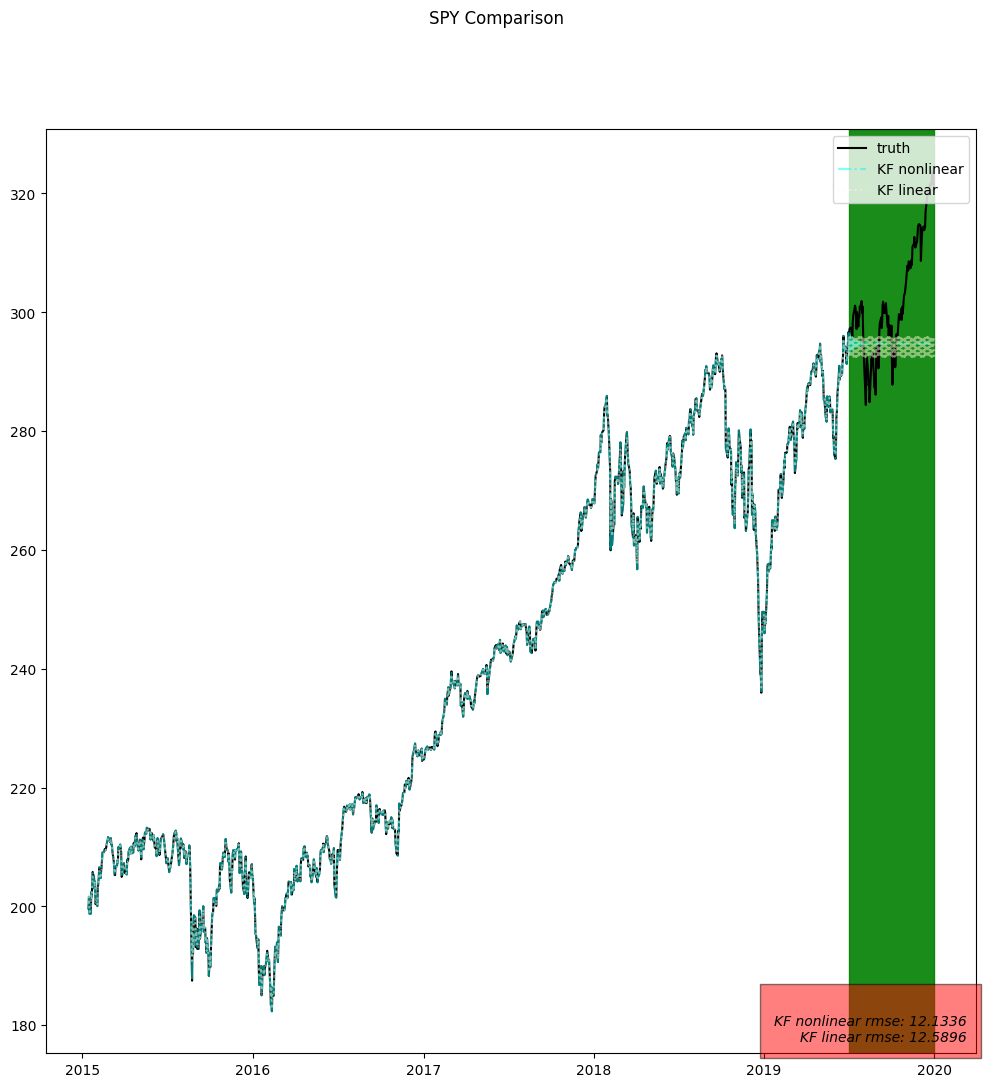

In [8]:
# full plot
plot_comparison(truth=observation.reshape(-1,1), observation=[n_train], model_result=result_set
                    , total_len=n_test + n_train, title="SPY Comparison", x=data.index,
                    additional_text=graph_text,init_pos=10)


true values
KF nonlinear
KF linear


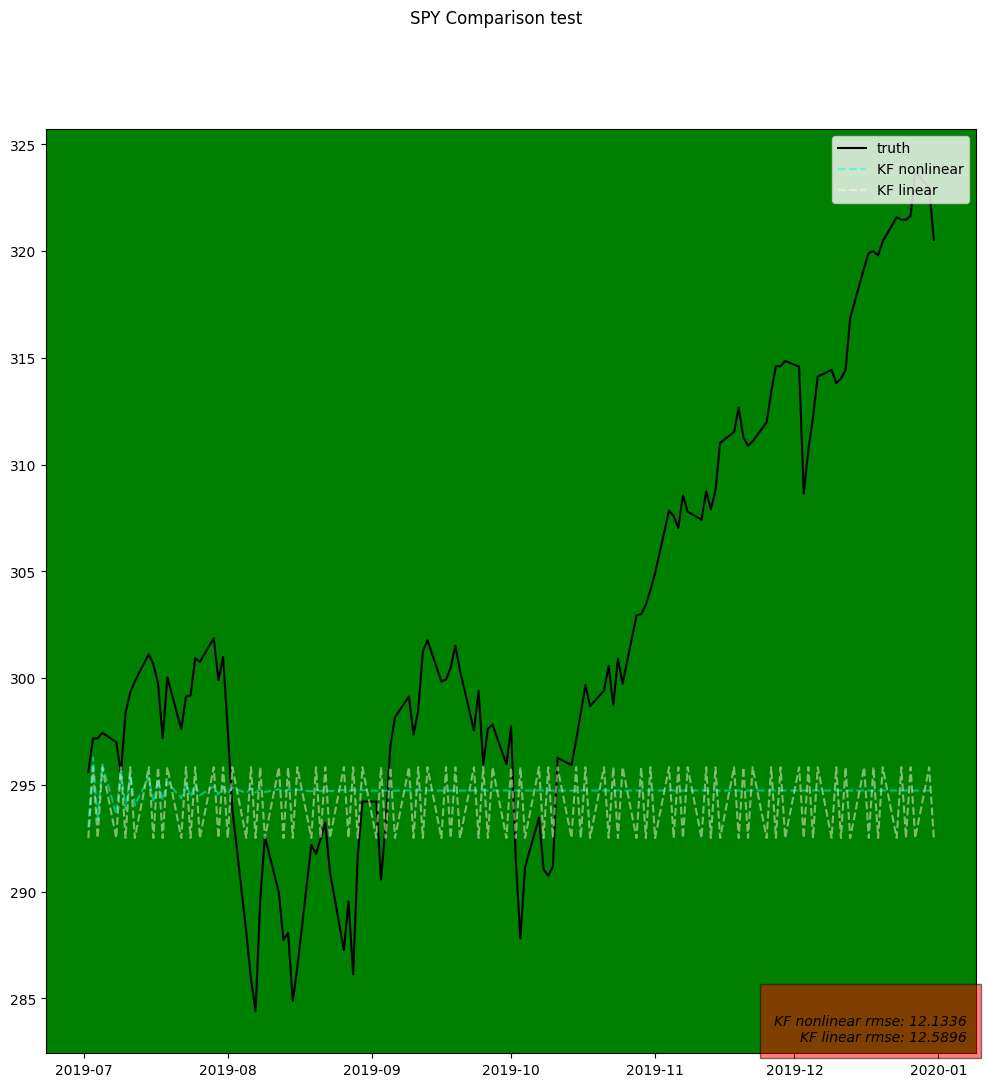

In [9]:
# test plot
plot_comparison(truth=observation.reshape(-1, 1), observation=[n_train], model_result=result_set
                    , total_len=n_test + n_train, title="SPY Comparison test", x=data.index,
                    additional_text=graph_text, init_pos=n_train)